In [300]:

######################### This version is meant to be a clone or Dr.Orlandi's version. Using his psych curve etc. goal is to clone behaviour. Will Implement objects.
######################### And then modify from there 

#gonna work in radians


In [301]:
#imports
import numpy as np
import sklearn.model_selection as sk
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as kb
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import random
from numba import jit

In [302]:
################### GLOBAL VARIABLES
NUMANGLES = 12 #how many orientations each side can take
MAXPROB = .9

TRIALSPERANGLE = 50

INFODIMENSION = 3

ANGLEMAX = np.pi/2
ANGLEMIN = -np.pi/2

MAX_EPOCHS = 1 # Total epochs
BATCH_SIZE = 210 # Trials per batch

NOCHOICEVAL = 1
LEFTCHOICEVAL = 0  #Value output when choosing left bar
RIGHTCHOICEVAL = 2 #Value output when choosing right bar

UNITS = 256 # Number of neurons in the dense layer
OUTPUT_SIZE = 3 # Number of output states
INPUT_DIMENSION = 3 #dimension of input. it will be 3 when there is attention included into model. 

STIMULUSDURATION = 1.5 #length of the stimulus (seconds)
PRESTIMULUSDURATION = 1 #length of the pre stimulus (seconds)

ONECHOICE = False #whether makes one choice and sticks or changes mind

FRAMERATE = 10 #(hz)

TOTALFRAMES = int(FRAMERATE*(STIMULUSDURATION + PRESTIMULUSDURATION)) #total number of frames

LASTFRAME = TOTALFRAMES - 1 #Index of last frame

ATTENTION_LEVELS = [0,1]  # Binary attention, currently -> low (0) or high (1)

PRESTIMULUSFRAME = int(PRESTIMULUSDURATION * FRAMERATE) - 1
STIMULUS_FRAME = PRESTIMULUSFRAME + 1
#################################################

In [303]:
class timeSeries:
    '''Class whose objects are times series of an instance'''
    #Initialize it with a time series

    def __init__(self, series):
        '''Initialization method. Stores an input list'''
        self.tSeries = series

In [304]:
class anglePair:
    '''Class whose objects are pairs of angles'''

    def __init__(self, angle1, angle2):
        '''Initialization method stores 2 input angles to the instance'''
        self.angle1 = angle1
        self.angle2 = angle2

In [305]:
class decisionMaker:
    '''Class that represents the agent making the decision'''
    def __init__(self, attention):
        '''initialization method sets the attention level of the instance'''
        self.attention = attention

    def _sameSign(self, angles):
        '''given a list of two angles the method return True if the angles have same sign. False if the angles have opposite sign'''
        angle1 = angles[0]
        angle2 = angles[1]
        return not abs(angle1 + angle2) < abs(angle1)+abs(angle2)

    def _difficulty(self, angles):
        '''Given two angles this function returns a difficulty from 0 - 1; 1 being hardest; 0 is easiest'''

        #Variable representing whether or not the angles are the same sign. (Point to the same side ([/ /]->same side) vs ([\ /]->opposite side)
        sameSign = self._sameSign(angles)

        #Find the magnitude of the difference of the angles
        difference = abs( abs(angles[0]) - abs(angles[1]) )

        beta = 0.1 #slope parameter for steepness of difficulty curve (a function of angle separation)

        #Set the y intercept of the inverse hyperbolic tangent
        if self.attention == 0:
            alpha = .5 #Alpha is the value of y intercept of the arctanh. Also the value of the difficulty of an infinite angle separation. Make it higher for low attention
        elif self.attention == 1:
            alpha = 0.2 #Make it lower for high attention

        offset = np.arctanh( 2*alpha - 1 )/beta #shift the graph so at x = 0 arctanh(g(x)) is alpha

        #Scaling Parameter. relates to d(difficulty)/d(angle separation)
        f = .4 
        if not sameSign: 
            #the angles are not the same side so add a bias to the difficulty
            y = 0.6  #Parameter that changes difficulty for a given angle separation depending on if they have the same sign [/ /] VS [\ /]
            
            #Shrink f by y 
            f = f - y*f 
        
        #scale it so small differences are large value and big differences are small. Map 0 to inf and inf to zero. Can try 1 - diff in future
        x = 1/(f*difference) 

        #Calculate and return difficulty
        dif = 1/2 * ( np.tanh( beta * (x + offset) ) + 1 )

        return dif

    def correctChoice(self, angles):
        '''input 2 angles return the smaller angle corresponding to more vertical orientation
        Angle 1 is left angle 2 is right. Returns -1 for Left 1 for right
        if they are equal error is thrown because currently only training on non equal angles
        '''
        global LEFTCHOICEVAL, RIGHTCHOICEVAL
        angle1 = angles[0]
        angle2 = angles[1]

        if abs(angle1) < abs(angle2):
            #The left bar is oriented more vertically
            return LEFTCHOICEVAL        
            
        elif abs(angle2) < abs(angle1):
            #The right bar is oriented more vertically
            return RIGHTCHOICEVAL       
        
        else:
            #throw error if angles are equal
            print("WEHAVEANERROR")
            return "Error. Not expecting equal angles" 
        
    def trainedChoice(self, angles):
        '''Input two angles returns the choice the mouse makes'''
        global MAXPROB, LEFTCHOICEVAL, RIGHTCHOICEVAL

        ####
     

        angDif = ( abs(angles[0]) - abs(angles[1]) )
        #angDifNoAb = ( abs(angles[0]) - abs(angles[1]) )
        ####
        #Calculate the probability that the decision maker is certain
        pCertain = self._probablilityCertain(self._difficulty(angles))

        #Check if the probCertain is larger than the maximum allowed certainty
        if pCertain > MAXPROB:
            #If probability certain is larger than the max allowed, then set it to the max
            pCertain = MAXPROB

        #print(diffic, "diffic", angDif)
        
        
        #Calculate the correct choice. (more vertically oriented)    
        cor = self.correctChoice(angles)
        
        info = [angDif, pCertain, cor]


        #Generate a random number in [0,1) and use it to determin whether the decision maker is certain or not
        n = np.random.random()
        if n <= pCertain: #they are certain
            #The decision maker is certain so return the correct answer
            return cor, info
        
        else:#not certain then it is a guess
            #generate a random number in [0,1) to decide which side the decision maker guesses
            g = np.random.random()
            if g < .5:
                #return the correct choice
                return cor, info
            else:
                #return the other choice
                if cor == RIGHTCHOICEVAL:
                    return LEFTCHOICEVAL, info
                else:
                    return RIGHTCHOICEVAL, info
                
    def _probablilityCertain(self, difficulty):
        '''return the probability of being certain as a function of difficulty'''
        #difficulty goes from 1 to 0. this flips it and maps a high difficulty to a low probability of being chosen
        p = -difficulty + 1
        return p

In [306]:
class timeSeriesCreationMachine:
    '''This class has objects that are machines to create time series. it will have configuration options and a method that spits out time series'''

    def createInputTimeSeries(self, anglePair, attention): #                                                                                                                                    (In future move attention solely into decisionMaker and have timeSeries class have an attribute for attention maybe)
        '''Input: ([angle1, angle2], attention)
           Output: timeSeries corresponding to input to network
             '''
        inputTimeSeries = timeSeries(np.zeros((TOTALFRAMES, INPUT_DIMENSION)).astype(np.float32)) #stores the trials time series'

        inputTimeSeries.tSeries[STIMULUS_FRAME:, 0] = anglePair[0]
        inputTimeSeries.tSeries[STIMULUS_FRAME:, 1] = anglePair[1]


        temporalNoiseScale = 10
        
        inputTimeSeries.tSeries[STIMULUS_FRAME:, 0] += np.random.randn()/temporalNoiseScale
        inputTimeSeries.tSeries[STIMULUS_FRAME:, 1] += np.random.randn()/temporalNoiseScale

        inputTimeSeries.tSeries[:, 2] = attention

        #return the time series
        return inputTimeSeries
                    
    def createOutputTimeSeries(self, inputTimeSeries, oneChoice):
        '''Input: the input time series, attention level, bool that determines if decisionMaker makes multiple choices
           Output: An output time series that is meant to be the desired output of the network when recieving the input time series'''
        
        #specify attention
        attention = inputTimeSeries.tSeries[0][2]
      
        #Initialize the response time series
        outputTimeSeries = timeSeries(np.full((TOTALFRAMES), np.nan)) 

        infoTimeSeries = timeSeries(np.full((TOTALFRAMES,INFODIMENSION), np.nan)) 

        #Instantiate a decision maker object
        decisionAgent = decisionMaker(attention)

        #Go through frames and create output time series
        for frame in range(TOTALFRAMES): 
            if frame < PRESTIMULUSFRAME: 
                outputTimeSeries.tSeries[frame] = np.nan
            elif frame == PRESTIMULUSFRAME:
                outputTimeSeries.tSeries[frame] = NOCHOICEVAL
            elif frame == STIMULUS_FRAME:
                firstTrainedChoice, info = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame])
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
                infoTimeSeries.tSeries[frame][0] = info[0]
                infoTimeSeries.tSeries[frame][1] = info[1]
                infoTimeSeries.tSeries[frame][2] = info[2]
            elif oneChoice == True:#when One choice is True one choice is made when stim is shown and that choice remains. when False It makes a decision each frame.
                outputTimeSeries.tSeries[frame] = firstTrainedChoice
                infoTimeSeries.tSeries[frame][0] = info[0]
                infoTimeSeries.tSeries[frame][1] = info[1]
                infoTimeSeries.tSeries[frame][2] = info[2]
            else:
                #use the angles corresponding to stimulus builds a distribution
                outputTimeSeries.tSeries[frame], infoTimeSeries.tSeries[frame] = decisionAgent.trainedChoice(inputTimeSeries.tSeries[frame]) ###ONE CONSTANT CHOICE OR CHOICE CHANGES
        return outputTimeSeries, infoTimeSeries                                                                                                          

In [307]:
class ensembleCreator:
    '''uses the timeSeriesCreator class to create an ensemble of iteration time series'''
    
    
    def generateEnsemble(self, attention):
        '''Input: An attention level, 
           Output: An ensemble of input and output time series corresponding to the input attention level. 
           (The input is what is fed into the network and the output is the desired network response)'''
        
        

        #Generate a list of valid angles for one side
        angleList = np.linspace(ANGLEMAX, ANGLEMIN, NUMANGLES)

        decimals = 1
        angles_grid = np.meshgrid(angleList, angleList)
        i_values = angles_grid[0].ravel()
        j_values = angles_grid[1].ravel()
        mask = (np.round(i_values, decimals) != np.round(j_values, decimals)) & (-np.round(i_values, decimals) != np.round(j_values, decimals))
       
        i_values = i_values[mask]
        j_values = j_values[mask]
        noiseScale = 20
        i_values += np.random.randn(len(i_values)) / noiseScale
        j_values += np.random.randn(len(j_values)) / noiseScale

        anglePairs = np.column_stack((j_values, i_values))

        #Randomize the order
        np.random.shuffle(anglePairs)

        #Determine the number of trials 
        numberTrials = len(anglePairs)

        #Instantiate a timeSeriesCreator
        timeSeriesCreator = timeSeriesCreationMachine()

        #Initialize trials input time series'
        inputList = np.zeros((numberTrials,TOTALFRAMES, INPUT_DIMENSION))

        #Initialize trials output time series'
        outputList = np.zeros((numberTrials, TOTALFRAMES))

        #initialize infoList
        infoList = np.array([])

        #Go through the trials and for each trial create an input and output time series
        for trial in range(numberTrials):
            #create input time series
            inputTimeSer = timeSeriesCreator.createInputTimeSeries(anglePairs[trial], attention) 
            
            #create output time series
            outputTimeSer, info = timeSeriesCreator.createOutputTimeSeries(inputTimeSer ,ONECHOICE)

            #append input time series to list of input trials
            inputList[trial] = inputTimeSer.tSeries

            #append output time series to list of output trials
            outputList[trial] = outputTimeSer.tSeries

            infoList = np.append(infoList, info.tSeries)
      

        #reshape and return the lists   
        infoList = infoList.reshape(numberTrials,TOTALFRAMES, INFODIMENSION)

        return inputList, outputList, infoList
    
    def generateEnsembles(self, attentionList):
        '''Input: a list of attention levels
           Output: an ensemble of trials at each attention level'''
        
        #Boolean representing if it is the first attention level. If first then a new list needs to be created. else the existing list should be appended to
        first = True

        #for each attention level create an ensemble of trials
        for j in range(TRIALSPERANGLE):
            for i in attentionList:
                trialsData, responseData, infoData = self.generateEnsemble(i)
                if first:
                    allTrials = trialsData
                    allResponses = responseData
                    allInfo = infoData
                    first = False
                else:
                    allTrials = np.concatenate((allTrials, trialsData), axis = 0)
                    allResponses = np.concatenate((allResponses, responseData), axis = 0)
                    allInfo =  np.concatenate((allInfo, infoData), axis = 0)
        return allTrials, allResponses, allInfo

In [308]:
class netModel:
    def _custom_loss(self, y_actual,y_pred): 
        '''calculates the loss using the frame immediately before stimulus and last frame of time series
        The frame before stim is to set p left and p right = 0'''
        l1 = kb.sparse_categorical_crossentropy(y_actual[:, PRESTIMULUSFRAME], y_pred[:, PRESTIMULUSFRAME])
        l2 = kb.sparse_categorical_crossentropy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
        custom_loss = l1 + l2
        return custom_loss

    def _custom_cat(self, y_actual,y_pred):
        '''Checks the accuracy of the final predicted output and compares it to the desired output'''
        l2 = tf.keras.metrics.sparse_categorical_accuracy(y_actual[:, LASTFRAME], y_pred[:, LASTFRAME])
        custom_cat = l2
        return custom_cat
    
    def genTestOutput(self):
        ensembleGen = ensembleCreator()

        trialsData, responseData, info = ensembleGen.generateEnsembles(ATTENTION_LEVELS)

        xTrain, xTest, yTrain, yTest = sk.train_test_split(
                                                            trialsData, 
                                                            responseData, 
                                                            test_size=0.25, 
                                                            random_state=None
                                                            )


    

        model = keras.models.Sequential()
        model.add(
                    Input(
                            shape = (
                                        xTrain.shape[1], 
                                        xTrain.shape[2]
                                        )
                            )
                    )
        model.add(layers.SimpleRNN(UNITS, activation = 'relu', return_sequences = True, name = 'rnn'))
        model.add(layers.BatchNormalization(name = 'batch_norm'))
        model.add(layers.Dense(OUTPUT_SIZE, activation = 'softmax', name = 'outputprobs'))

       # model.summary()
        metrr = ['accuracy', self._custom_cat]

        model.compile(
                        loss=self._custom_loss,
                        optimizer="adam",
                        metrics=metrr
                        )

        model.fit(
                    xTrain, 
                    yTrain, 
                    epochs = MAX_EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = True, 
                    validation_data = (
                                        xTest, 
                                        yTest
                                        )
                    )
        yTestPredict = model.predict(xTest)
        return xTest, yTestPredict, info, yTest


In [309]:
class main:
    def __init__(self):
        '''Trains network and plots test output'''
        mod = netModel()

        xTest, yTestPredict, info, yTest = mod.genTestOutput()

        fig, ax = plt.subplots(3,1, sharex = True,sharey = True)
        x = []
        y = []
        pLeft = []
        pRight = []
        correct = []
        for g in info:
            for i in g:
                if (i[0] > -100) & (i[1] > -100):#use np.equals
                    x.append(i[0]) #angDif
                    y.append(i[1]) #pCertain
                    
                    if i[2] == LEFTCHOICEVAL:
                        pLeftVal = i[1] + .5*(1- i[1])
                        pRightVal = 1 - pLeftVal

                    elif i[2] == RIGHTCHOICEVAL:
                        pRightVal = i[1] + .5*(1- i[1])
                        pLeftVal = 1 - pRightVal

                    else:
                        print("Error")

                    pLeft.append(pLeftVal)
                    pRight.append(pRightVal)

                    
        
        #probability certain curve
        #Use it to generate prob left prob right
        ax[0].plot(x,pLeft, 'or', markersize = 0.3)
        ax[1].plot(x,pRight, 'ob', markersize = 0.3)


        

        probRightListHighAttSameSignCorrect = []
        probRightListLowAttSameSignCorrect = []
        probRightListHighAttOppSignCorrect = []
        probRightListLowAttOppSignCorrect = []

        probLeftListHighAttSameSignCorrect = []
        probLeftListLowAttSameSignCorrect = []
        probLeftListHighAttOppSignCorrect = []
        probLeftListLowAttOppSignCorrect = []

        probRightListHighAttSameSignInCorrect = []
        probRightListLowAttSameSignInCorrect = []
        probRightListHighAttOppSignInCorrect = []
        probRightListLowAttOppSignInCorrect = []

        probLeftListHighAttSameSignInCorrect = []
        probLeftListLowAttSameSignInCorrect = []
        probLeftListHighAttOppSignInCorrect = []
        probLeftListLowAttOppSignInCorrect = []
        

        highAttSameSignAngListRight = []
        lowAttSameSignAngListRight = []
        highAttOppSignAngListRight = []
        lowAttOppSignAngListRight = []
        highAttSameSignAngListLeft = []
        lowAttSameSignAngListLeft = []
        highAttOppSignAngListLeft = []
        lowAttOppSignAngListLeft = []
        

        counter = 0

        HighAtt = True
        SameSign = True
 
        for trial in yTest:
            x = 0
            trialList = []

            for frame in trial:
                x = 0
                if ((frame > -1) & (frame != 1.0)):
                    trialList.append(frame)
            leftCount = 0 
            rightCount = 0       
            for i in trialList:
                if i == LEFTCHOICEVAL:
                    leftCount += 1
                else:
                    rightCount += 1

            numDecision = len(trialList)# num frames
    
            probLeft = leftCount/numDecision
            probRight = rightCount/numDecision

            angle1 = xTest[counter][STIMULUS_FRAME][0]
            angle2 = xTest[counter][STIMULUS_FRAME][1]
            angleDif = (abs(angle1) - abs(angle2))
            attent = xTest[counter][STIMULUS_FRAME][2]
            SameSign = not abs(angle1 + angle2) < abs(angle1)+abs(angle2)
            
            left = abs(angle1)<abs(angle2) 
            if attent == 0:#low Attention
                if SameSign:#Same sign
                    if left:
                        probLeftListLowAttSameSignCorrect.append(probLeft)
                        probRightListLowAttSameSignInCorrect.append(probRight)
                        lowAttSameSignAngListLeft.append(angleDif)
                    else:
                        probLeftListLowAttSameSignInCorrect.append(probLeft)
                        probRightListLowAttSameSignCorrect.append(probRight)
                        lowAttSameSignAngListRight.append(angleDif)

                else:#opp sign
                    if left:
                        probLeftListLowAttOppSignCorrect.append(probLeft)
                        probRightListLowAttOppSignInCorrect.append(probRight)
                        lowAttOppSignAngListLeft.append(angleDif)
                    else:
                        probLeftListLowAttOppSignInCorrect.append(probLeft)
                        probRightListLowAttOppSignCorrect.append(probRight)
                        lowAttOppSignAngListRight.append(angleDif)
            
            else: #High attention
                if SameSign:  #same sign
                    if left:
                        probLeftListHighAttSameSignCorrect.append(probLeft)
                        probRightListHighAttSameSignInCorrect.append(probRight)
                        highAttSameSignAngListLeft.append(angleDif)
                    else:
                        probLeftListHighAttSameSignInCorrect.append(probLeft)
                        probRightListHighAttSameSignCorrect.append(probRight)
                        highAttSameSignAngListRight.append(angleDif)

                else: #opp sign
                    if left:
                        probLeftListHighAttOppSignCorrect.append(probLeft)
                        probRightListHighAttOppSignInCorrect.append(probRight)
                        highAttOppSignAngListLeft.append(angleDif)

                    else:
                        probLeftListHighAttOppSignInCorrect.append(probLeft)
                        probRightListHighAttOppSignCorrect.append(probRight)
                        highAttOppSignAngListRight.append(angleDif)



            counter += 1

       # ax[2].plot(highAttSameSignAngListRight, probRightListHighAttSameSignCorrect,'ro')

        def binner(angleList, probList, start, stop):
           
            errScale = 25
            err = (stop - start)/errScale
            numBins = 16
            numPoints = numBins + 1
            bins = np.linspace(start- err, stop + err, numPoints)
            hist = np.zeros((numBins,2))
            ranger = bins[1] - bins[0]
            dx = ranger/2
            spot = start
            for i in range(len(bins)):
                if i < len(bins)-1  :
                    loc = spot + dx 
                    hist[i][0] = loc
                    count = 0
                    totP = 0
                    for j in range(len(probList)):
                        if (angleList[j] < spot + ranger) & (angleList[j]>= spot):
                            count += 1
                            totP += probList[j]
                    if count != 0:
                        avgP = totP/count
                    else:
                        avgP = 0
                    hist[i][1] = avgP
                    spot += ranger
            return hist
                
      
        


        hist1 = binner(highAttSameSignAngListRight,probRightListHighAttSameSignCorrect, 0 , np.pi/2 )
        hist2 = binner(highAttSameSignAngListLeft,probRightListHighAttSameSignInCorrect, -np.pi/2 , 0 )

        hist3 = binner(lowAttSameSignAngListRight,probRightListLowAttSameSignCorrect, 0 , np.pi/2 )
        hist4 = binner(lowAttSameSignAngListLeft,probRightListLowAttSameSignInCorrect, -np.pi/2 , 0  )

        hist5 = binner(highAttOppSignAngListRight,probRightListHighAttOppSignCorrect, 0 , np.pi/2 )
        hist6 = binner(highAttOppSignAngListLeft,probRightListHighAttOppSignInCorrect, -np.pi/2 , 0 )

        hist7 = binner(lowAttOppSignAngListRight,probRightListLowAttOppSignCorrect, 0 , np.pi/2 )
        hist8 = binner(lowAttOppSignAngListLeft,probRightListLowAttOppSignInCorrect, -np.pi/2 , 0  )

        hist9 = binner(highAttSameSignAngListLeft,probLeftListHighAttSameSignCorrect, -np.pi/2 , 0  )
        hist10 = binner(highAttSameSignAngListRight,probLeftListHighAttSameSignInCorrect, 0 , np.pi/2 )

        hist11 = binner(lowAttSameSignAngListLeft,probLeftListLowAttSameSignCorrect, -np.pi/2 , 0 )
        hist12 = binner(lowAttSameSignAngListRight,probLeftListLowAttSameSignInCorrect, 0 , np.pi/2 )

        hist13 = binner(highAttOppSignAngListLeft,probLeftListHighAttOppSignCorrect, -np.pi/2 , 0 )
        hist14 = binner(highAttOppSignAngListRight,probLeftListHighAttOppSignInCorrect, 0 , np.pi/2 )

        hist15 = binner(lowAttOppSignAngListLeft,probLeftListLowAttOppSignCorrect, -np.pi/2 , 0  )
        hist16 = binner(lowAttOppSignAngListRight,probLeftListLowAttOppSignInCorrect, 0 , np.pi/2 )

        histList1 = [hist1,hist3,hist5,hist7,hist2,hist4,hist6,hist8]
        histList2 = [hist9,hist10,hist11,hist12,hist13, hist14, hist15, hist16]
        for hist in histList1:
            for i in hist:
                ax[2].plot(i[0],i[1], 'ob', markersize = 0.9)
        for hist in histList2:
            for i in hist:
                ax[2].plot(i[0],i[1], 'or', markersize = 0.9)       
        
        '''
        indexHighAtt = []
        indexLowAtt = []
        for i in range(len(xTest)):
            if xTest[i][0][2] == 0:
                indexLowAtt.append(i)
            else:
                indexHighAtt.append(i)
        
        numCol = 4

        row2 = random.sample(indexLowAtt, numCol)
        row1 = random.sample(indexHighAtt, numCol)

        fig, ax = plt.subplots(2, numCol, sharex = True, sharey = True, figsize = (20,10))

        for i in range(len(row1)):
            l1 = []
            l2 = []
            l3 = []
            for j in yTestPredict[row1[i]]: 
                l1.append(j[0])
                l2.append(j[1])
                l3.append(j[2])
          
            ax[0][i].plot(l1)        #PLOT the high attention trials
            ax[0][i].plot(l2)
            ax[0][i].plot(l3)
        for i in range(len(row2)):
            l1 = []
            l2 = []
            l3 = []
            for j in yTestPredict[row2[i]]:
                l1.append(j[0])
                l2.append(j[1])
                l3.append(j[2])
                
            ax[1][i].plot(l1)     #Plot the low attention trials
            ax[1][i].plot(l2)
            ax[1][i].plot(l3)
        '''

        plt.show()
             

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - _custom_cat: 0.5780 - accuracy: 0.3132 - loss: 0.9804 - val__custom_cat: 0.4983 - val_accuracy: 0.3279 - val_loss: 1.7138
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


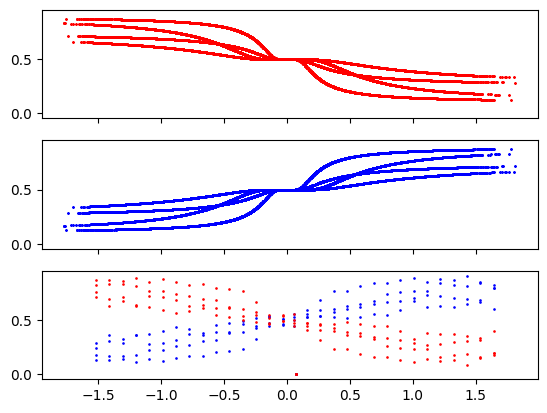

In [310]:
run = main()